In [1]:
# Data
import numpy as np
import pandas as pd

# NLP
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn import svm

# plot
import matplotlib.pyplot as plt

ps = PorterStemmer()
stopwords_english = set(stopwords.words('english'))

# 1. Load Data 

In [2]:
PATH = "./Data/All_Candidates/"
biden = pd.read_csv(PATH + 'Joe_Biden.csv')
sanders = pd.read_csv(PATH + 'Bernie_Sanders.csv')
trump = pd.read_csv(PATH + 'Donald_Trump.csv')

In [3]:
trump.head()

,title,text,media,word_count,candidate_name
0,Primary Battles on the Right? They Seem Less S...,Hide highlightingFull TextTranslateUndo Transl...,New York Times,1880.0,Donald Trump
1,Collins Will Not Support Removal of the Presid...,Full TextTranslateUndo Translation FromToTrans...,New York Times,1066.0,Donald Trump
2,Trump's Legal Warrior Jabs Back at His Boss. I...,Hide highlightingFull TextTranslateUndo Transl...,New York Times,1578.0,Donald Trump
3,"When America's Oddest Political Couple Fight, ...",Hide highlightingFull TextTranslateUndo Transl...,New York Times,1679.0,Donald Trump
4,Disagreement on Extent Of Moscow's Meddling: [...,Full TextTranslateUndo Translation FromToTrans...,New York Times,1090.0,Donald Trump


# 2. Hand Annotate Articles 

In [4]:
# hand annotation indicies
# Biden
positive_biden = [24, 27, 28, 35, 47, 48, 51, 57, 63, 72, 86, 98, 173, 198, 219, 268, 343, 358, 369, 420]

negative_biden = [374,156,106,85,171,172,174,186,192,222,229,235,110,6,277,313,356,368,49]

neutral_biden = [150,445,161,183,227,250,29,159,240,260,283,305,325,332,341,357,370,380,398,402]

# Sanders
positive_sanders = [4, 11, 12, 18, 27, 29, 31, 33, 37, 42, 48, 51, 60, 67, 70, 74, 76, 80, 85, 89]

negative_sanders = [0, 5, 10, 15, 20, 22, 23, 28, 30, 35, 39, 41, 43, 46, 49, 50, 59, 61, 63, 66]

neutral_sanders = [1, 2, 3, 6, 7, 9, 13, 16, 17, 19, 21, 24, 26, 32, 37, 38, 45, 47, 52, 75]

# Trump
positive_trump = [447,408, 395, 389, 377, 374, 372, 320, 321, 323, 324, 326, 344, 346, 348, 349, 355, 106, 338, 419]

negative_trump = [448, 396, 394, 1, 2, 3, 6, 7, 9, 10, 11, 12, 17, 18, 100, 332, 120, 29, 30, 36, 48]

neutral_trump = [443, 432, 418, 398, 373, 365, 364, 4, 5, 8, 14, 16, 19, 253, 300, 310, 325, 328, 341, 352]

In [5]:
def generate_sentiments_df(candidate_df, positive_idx, negative_idx, neutral_idx):
    # add labels
    candidate_df['sentiment'] = "labels"
    candidate_df.loc[positive_idx, ['sentiment']] = "pos"
    candidate_df.loc[negative_idx, ['sentiment']] = "neg"
    candidate_df.loc[neutral_idx, ['sentiment']] = "neutral"
    # retain useful rows
    candidate_df = candidate_df[candidate_df['sentiment'] != "labels"]
    # select useful columns
    df_new = candidate_df[['text', 'sentiment']]
    return df_new


In [6]:
biden_sentiment = generate_sentiments_df(candidate_df = biden, positive_idx = positive_biden,
                                         negative_idx = negative_biden, neutral_idx = neutral_biden)
sanders_sentiment = generate_sentiments_df(candidate_df = sanders, positive_idx = positive_sanders,
                                         negative_idx = negative_sanders, neutral_idx = neutral_sanders)
trump_sentiment = generate_sentiments_df(candidate_df = trump, positive_idx = positive_trump,
                                         negative_idx = negative_trump, neutral_idx = neutral_trump)

In [7]:
# concate all candidates dfs for modeling
df = pd.concat([biden_sentiment, sanders_sentiment, trump_sentiment], axis = 0, ignore_index = True)
df.head()

,text,sentiment
0,Hide highlightingFull TextTranslateUndo Transl...,neg
1,Hide highlightingFull TextTranslateUndo Transl...,pos
2,Hide highlightingFull TextTranslateUndo Transl...,pos
3,Hide highlightingAbstractTranslateUndo Transla...,pos
4,Hide highlightingFull TextTranslateUndo Transl...,neutral


In [8]:
# check
df.groupby('sentiment').count()

,text
sentiment,
neg,60
neutral,60
pos,59


# 3. Data Preprocessing

In [9]:
def Data_Preprocessing(corpus):
    # convert string to list i.e. ['hide', 'highlightingfull', '[[missing']
    corpus['text'] = corpus['text'].str.split()

    # lower case each item in the list, and remove non-alphabetic characters i.e. ['hide', 'highlightingfull', 'missing']
    corpus['text'] = corpus['text'].apply(lambda x: [re.sub(r'[^a-zA-Z]', "",y.lower()) for y in x])

    # stem each word in the text
    corpus['text'] = corpus['text'].apply(lambda x: [ps.stem(y) for y in x])

    # join the item in the list back to a string
    corpus['text'] = corpus['text'].apply(lambda x: [' '.join(x)])

    # convert list to a string
    corpus['text'] = corpus['text'].apply(lambda x: str(x[0]))

    print(type(corpus.iloc[0]['text']))
    
    return corpus

In [10]:
processed_sentiment_corpus = Data_Preprocessing(df)
processed_sentiment_corpus.head(2)

<class 'str'>


,text,sentiment
0,hide highlightingful texttranslateundo transla...,neg
1,hide highlightingful texttranslateundo transla...,pos


# 4. Modeling

## 4.1 Split training and test sets

In [11]:
# separate features and targets
X = processed_sentiment_corpus.iloc[:, 0]
y = processed_sentiment_corpus.iloc[:, 1]

# split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=0)
#X_train, y_train = shuffle(X_train, y_train)

X_train.head(2)

22    full texttranslateundo translat fromtotranslat...
31    hide highlightingful texttranslateundo transla...
Name: text, dtype: object

In [12]:
le = LabelEncoder()
# get label name mapping
le.fit(y_train)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

# encode the target 
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

{'neg': 0, 'neutral': 1, 'pos': 2}


## 4.2 Getting document term matrices

### 4.2.1 Create matrix of token counts using unigram, bigram and trigram tokens

In [13]:
# define a function to get unigram, bigram, and trigram matrix of token counts

def get_DTM(Ngram_range, x_train, x_test):
    vectorizer = CountVectorizer(stop_words='english', min_df = int(3), max_df = 0.5, 
                                 ngram_range = Ngram_range, binary=True) 
    vectorizer.fit(x_train)
    trans_x_train = vectorizer.transform(x_train)
    trans_x_test = vectorizer.transform(x_test)
    
    return trans_x_train, trans_x_test

In [14]:
# unigram token counts matrix
binary1_train, binary1_test = get_DTM(Ngram_range = (1, 1), x_train = X_train, x_test = X_test)

# bigram token counts matrix
binary2_train, binary2_test = get_DTM(Ngram_range = (1, 2), x_train = X_train, x_test = X_test)

# trigram token counts matrix
binary3_train, binary3_test = get_DTM(Ngram_range = (1, 3), x_train = X_train, x_test = X_test)

In [15]:
print("The unique terms in binary1_train is:", binary1_train.toarray().shape[1])
print("The unique terms in binary2_train is:", binary2_train.toarray().shape[1])
print("The unique terms in binary3_train is:", binary3_train.toarray().shape[1])

The unique terms in binary1_train is: 3437
The unique terms in binary2_train is: 7950
The unique terms in binary3_train is: 9424


### 4.2.2 Create DTM using unigram, bigram and trigram term frequency

In [16]:
# define a function to get unigram, bigram, and trigram term frequency matrix

def get_TF_DTM(Ngram_range, x_train, x_test):
    vectorizer = CountVectorizer(stop_words='english', min_df = int(3), max_df = 0.5, ngram_range = Ngram_range) 
    vectorizer.fit(x_train)
    trans_x_train = vectorizer.transform(x_train)
    trans_x_test = vectorizer.transform(x_test)
    
    return trans_x_train, trans_x_test

In [17]:
# unigram tf matrix
tf1_train, tf1_test = get_TF_DTM(Ngram_range = (1, 1), x_train = X_train, x_test = X_test)

# bigram tf matrix
tf2_train, tf2_test = get_TF_DTM(Ngram_range = (1, 2), x_train = X_train, x_test = X_test)

# trigram tf matrix
tf3_train, tf3_test = get_TF_DTM(Ngram_range = (1, 3), x_train = X_train, x_test = X_test)

In [18]:
print("The unique terms in tf1_train is:", tf1_train.toarray().shape[1])
print("The unique terms in tf2_train is:", tf2_train.toarray().shape[1])
print("The unique terms in tf3_train is:", tf3_train.toarray().shape[1])

The unique terms in tf1_train is: 3437
The unique terms in tf2_train is: 7950
The unique terms in tf3_train is: 9424


### 4.2.3 Create DTM using unigram, bigram and trigram TF-IDF

In [19]:
# define a function to get unigram, bigram, and trigram TF-IDF matrix

def get_TF_IDF_DTM(Ngram_range, x_train, x_test):
    vectorizer = TfidfVectorizer(stop_words='english', min_df = int(3), max_df = 0.5, 
                                 ngram_range = Ngram_range) 
    vectorizer.fit(x_train)
    trans_x_train = vectorizer.transform(x_train)
    trans_x_test = vectorizer.transform(x_test)
    
    return trans_x_train, trans_x_test

In [20]:
# unigram tf-idf matrix
tfidf1_train, tfidf1_test = get_TF_IDF_DTM(Ngram_range = (1, 1), x_train = X_train, x_test = X_test)

# bigram tf-idf matrix
tfidf2_train, tfidf2_test = get_TF_IDF_DTM(Ngram_range = (1, 2), x_train = X_train, x_test = X_test)

# trigram tf-idf matrix
tfidf3_train, tfidf3_test = get_TF_IDF_DTM(Ngram_range = (1, 3), x_train = X_train, x_test = X_test)

In [21]:
print("The unique terms in tfidf1_train is:", tfidf1_train.toarray().shape[1])
print("The unique terms in tfidf2_train is:", tfidf2_train.toarray().shape[1])
print("The unique terms in tfidf3_train is:", tfidf3_train.toarray().shape[1])

The unique terms in tfidf1_train is: 3437
The unique terms in tfidf2_train is: 7950
The unique terms in tfidf3_train is: 9424


## 4.3 Modeling

### 4.3.1 XGBoost Classifier

In [22]:
# define model training
def train_model(clf, dtm, test):
    # train data
    clf.fit(dtm, y_train)
    
    # Predicting on the test set
    preds = clf.predict(test)
    
    # print evaluation matrix
    print("Macro f1-score:", '{:1.4f}'.format(f1_score(y_test, preds, average='macro')))
    print("") 
    print(classification_report(y_test, preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    
    return '{:1.4f}'.format(f1_score(y_test, preds, average='macro'))

In [23]:
# Use XGboost
#clf = XGBClassifier() #MultinomialNB()
param = {'max_depth': 3, 'eta': 0.1, 'objective':'multi:softmax', 'num_class': 3}
xgb_clf = XGBClassifier(param)
svm_clf = svm.SVC(gamma = 'scale', C = 1.0)
# reference: https://medium.com/@gabrielziegler3/multiclass-multilabel-classification-with-xgboost-66195e4d9f2d
# reference: https://xgboost.readthedocs.io/en/latest/parameter.html

# Model Configurations
binary1 = ("unigram, binary", binary1_train, binary1_test)
binary2 = ("bigram, binary",  binary2_train, binary2_test)
binary3 = ("trigram, binary", binary3_train, binary3_test)
tf1 = ("unigram, TF", tf1_train, tf1_test)
tf2 = ("bigram, TF",  tf2_train, tf2_test)
tf3 = ("trigram, TF", tf3_train, tf3_test)
tfidf1 = ("unigram, TF-IDF", tfidf1_train, tfidf1_test)
tfidf2 = ("bigram, TF-IDF",  tfidf2_train, tfidf2_test)
tfidf3 = ("trigram, TF-IDF", tfidf3_train, tfidf3_test)
DTMs = [binary1, binary2, binary3,
        tf1, tf2, tf3,
        tfidf1, tfidf2, tfidf3]

df = pd.DataFrame({"config": [],
                   "f1-score": []})
best_config = ["Best Configuration", "none", 0, "none", "none"]
for data in DTMs:
    print(data[0])
    print("")
    score = train_model(clf = xgb_clf, dtm = data[1], test = data[2])
    print("======================================================")
    print("")
    if float(score) > float(best_config[2]):
        best_config = ["Best Configuration:", data[0], score, data[1], data[2]]
    df = df.append({"config": data[0],
               "f1-score": float(score)},
               ignore_index=True)

unigram, binary

Macro f1-score: 0.4091

              precision    recall  f1-score   support

           0       0.43      0.50      0.46        12
           1       0.46      0.50      0.48        12
           2       0.33      0.25      0.29        12

    accuracy                           0.42        36
   macro avg       0.41      0.42      0.41        36
weighted avg       0.41      0.42      0.41        36

Confusion Matrix:
[[6 3 3]
 [3 6 3]
 [5 4 3]]

bigram, binary

Macro f1-score: 0.4139

              precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.43      0.50      0.46        12
           2       0.40      0.33      0.36        12

    accuracy                           0.42        36
   macro avg       0.42      0.42      0.41        36
weighted avg       0.42      0.42      0.41        36

Confusion Matrix:
[[5 4 3]
 [3 6 3]
 [4 4 4]]

trigram, binary

Macro f1-score: 0.3969

              precisio

In [24]:
# results of xgb classifier
df

,config,f1-score
0,"unigram, binary",0.4091
1,"bigram, binary",0.4139
2,"trigram, binary",0.3969
3,"unigram, TF",0.3563
4,"bigram, TF",0.3484
5,"trigram, TF",0.3790
6,"unigram, TF-IDF",0.4437
7,"bigram, TF-IDF",0.4091
8,"trigram, TF-IDF",0.4051


In [25]:
# best model
print(best_config)

['Best Configuration:', 'unigram, TF-IDF', '0.4437', <143x3437 sparse matrix of type '<class 'numpy.float64'>'
	with 42973 stored elements in Compressed Sparse Row format>, <36x3437 sparse matrix of type '<class 'numpy.float64'>'
	with 10508 stored elements in Compressed Sparse Row format>]


### 4.3.1.1 Feature Importance Analysis 

In [26]:
# Best Configuration
xgb_clf.fit(best_config[3], y_train)

# predictions on the test data
preds = xgb_clf.predict(best_config[4])

# feature importance
importances = xgb_clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
vectorizer = TfidfVectorizer(stop_words='english', min_df = int(3), max_df = 0.5, ngram_range = (1, 1))
vectorizer.fit(X_train)
names = [vectorizer.get_feature_names()[i] for i in indices]

In [27]:
# Main features
names[0:20]

['number',
 'instal',
 'assess',
 'comment',
 'post',
 'favor',
 'battleground',
 'success',
 'ran',
 'letter',
 'socialist',
 'histori',
 'journal',
 'vermont',
 'economi',
 'campaignth',
 'solidifi',
 'fundament',
 'bank',
 'let']

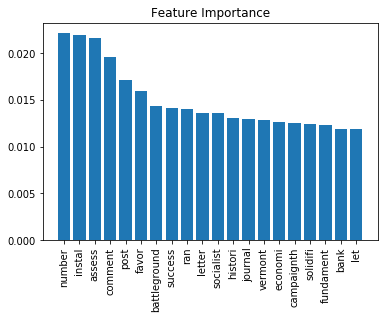

In [28]:
num_features = 20

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(num_features), importances[indices][0:num_features])

# Add feature names as x-axis labels
plt.xticks(range(num_features), names[0:num_features], rotation=90)

# Show plot
plt.show()

### 4.3.2 SVM Classifier

In [29]:
# svm classifier
df_svm = pd.DataFrame({"config": [],
                   "f1-score": []})
best_config_svm = ["Best Configuration", "none", 0, "none", "none"]
for data in DTMs:
    print(data[0])
    print("")
    score = train_model(clf = svm_clf, dtm = data[1], test = data[2])
    print("======================================================")
    print("")
    if float(score) > float(best_config_svm[2]):
        best_config_svm = ["Best Configuration:", data[0], score, data[1], data[2]]
    df_svm = df_svm.append({"config": data[0],
               "f1-score": float(score)},
               ignore_index=True)

unigram, binary

Macro f1-score: 0.4077

              precision    recall  f1-score   support

           0       0.50      0.58      0.54        12
           1       0.38      0.25      0.30        12
           2       0.36      0.42      0.38        12

    accuracy                           0.42        36
   macro avg       0.41      0.42      0.41        36
weighted avg       0.41      0.42      0.41        36

Confusion Matrix:
[[7 1 4]
 [4 3 5]
 [3 4 5]]

bigram, binary

Macro f1-score: 0.3814

              precision    recall  f1-score   support

           0       0.50      0.58      0.54        12
           1       0.33      0.25      0.29        12
           2       0.31      0.33      0.32        12

    accuracy                           0.39        36
   macro avg       0.38      0.39      0.38        36
weighted avg       0.38      0.39      0.38        36

Confusion Matrix:
[[7 1 4]
 [4 3 5]
 [3 5 4]]

trigram, binary

Macro f1-score: 0.3814

              precisio

In [30]:
# results of svm classifier
df_svm

,config,f1-score
0,"unigram, binary",0.4077
1,"bigram, binary",0.3814
2,"trigram, binary",0.3814
3,"unigram, TF",0.3951
4,"bigram, TF",0.3988
5,"trigram, TF",0.4026
6,"unigram, TF-IDF",0.4727
7,"bigram, TF-IDF",0.4482
8,"trigram, TF-IDF",0.4482


In [31]:
# best model
print(best_config_svm)

['Best Configuration:', 'unigram, TF-IDF', '0.4727', <143x3437 sparse matrix of type '<class 'numpy.float64'>'
	with 42973 stored elements in Compressed Sparse Row format>, <36x3437 sparse matrix of type '<class 'numpy.float64'>'
	with 10508 stored elements in Compressed Sparse Row format>]
